In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from src.preprocessing import prepare_data
from src.utils import plot_forecast, calculate_ic
import seaborn as sns
sns.set_style("dark")
sns.set_palette("dark")

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from datetime import datetime, date

# Sarima

Em modelos regressivos temporais, como ARIMA, multicolinearidade pode causar problemas de estimativa instável dos coeficientes, especialmente quando muitas variáveis (ou "lags") estão presentes e são fortemente correlacionadas. Isso é chamado de "curse of dimensionality" e afeta a precisão da previsão, além de dificultar a interpretação dos coeficientes. O excesso de lags correlacionados também pode levar a overfitting, onde o modelo se ajusta muito bem ao histórico, mas perde capacidade de generalizar para dados futuros.

In [2]:
df = pd.read_csv("../data/jena_climate_2009_2016.csv")
df = prepare_data(df)
target = "temperature_celsius"
df = df.set_index("date")
df.index = pd.DatetimeIndex(df.index.values,freq="h")
df.head()

,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,wind_speed,maximum_wind_speed,wind_direction_degree,days_since_beginning,year
2009-01-01 00:00:00,996.528000,-8.304000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000,0,2009
2009-01-01 01:00:00,996.525000,-8.065000,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667,0,2009
2009-01-01 02:00:00,996.745000,-8.763333,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667,0,2009
2009-01-01 03:00:00,996.986667,-8.896667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333,0,2009
2009-01-01 04:00:00,997.158333,-9.348333,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333,0,2009


In [3]:
exog_variables = ['internal_pressure',
 'dew_point',
 'relative_humidity',
 'saturation_vapor_pressure',
 'vapor_pressure',
 'vapor_pressure_deficit',
#  'specific_humidity', 100% corr com vapor pressure
#  'water_vapor_concentration', 100% corr com vapor pressure
 'airtight',
 'wind_speed',
#  'maximum_wind_speed', 99% corr com wind speed
 'wind_direction_degree',
 'days_since_beginning',
 'year']

df[exog_variables] = df[exog_variables].shift(1)

In [4]:
df.ffill(inplace=True)

## Autocorrelação e Autocorrelação Parcial

### ACF
ACF calcula a correlação entre as observações de uma série temporal com observações no passado, em lags diferentes, sem remover o efeito dos lags intermediários.

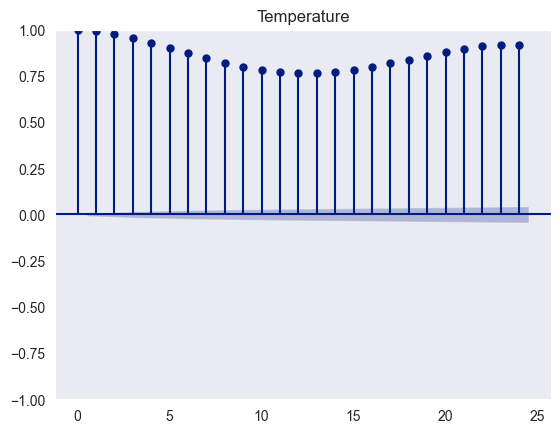

In [5]:
sm.graphics.tsa.plot_acf(df[target],lags = 24, title = 'Temperature')
plt.show()

> Correlação alta em todos os lags:

A correlação para os primeiros 25 lags é alta e lentamente decrescente, permanecendo bem acima da linha de confiança.
Isso sugere uma forte autocorrelação persistente, indicando que o valor da temperatura atual está fortemente relacionado com os valores passados, mesmo para lags distantes.

> Decaimento lento:

O decaimento lento da autocorrelação sugere a presença de uma tendência ou sazonalidade na série. Para dados de temperatura, isso faz sentido, pois há um padrão sazonal (ex.: diário ou anual).

> Significância estatística:

A maioria das barras está fora das bandas de confiança (área sombreada). Isso significa que quase todos os lags exibidos são estatisticamente significativos, ou seja, há dependência serial na série temporal.

> Conclusão: Essa queda "lenta" da correlação, aliada ao resultado da Dickey-Fuller, indica fortemente a presença da sazonalidade e a necessidade de diferenciar a série para lidar com a não estacionaridade.

### PACF
A PACF, por outro lado, é usada para verificar a relação direta entre uma observação em um momento específico e seus valores defasados, enquanto remove efetivamente a influência de defasagens mais curtas. 
Isso significa que a PACF(x) fornece a correlação entre a série e ela mesma com defasagem de “x” períodos de tempo, depois de considerar a dependência linear da série em defasagens menores, isolando assim o efeito direto de uma defasagem específica.

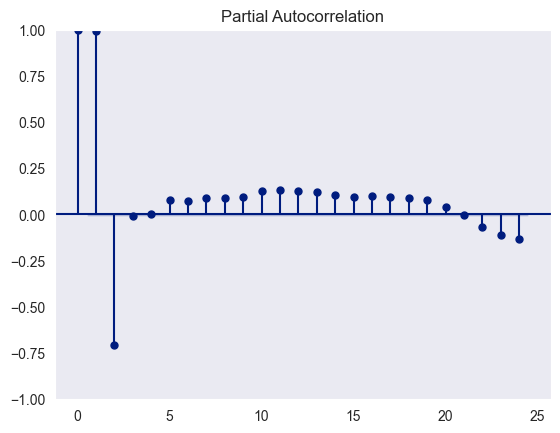

In [6]:
sm.graphics.tsa.plot_pacf(df[target],lags = 24)
plt.show()

> Lag 1 e Lag 2:

No seu gráfico, o coeficiente de correlação parcial é próximo de 1 para o lag 1 e próximo de -0.8 para o lag 2, indicando uma forte correlação (positiva e negativa, respectivamente).
Isso sugere que a série temporal possui uma dependência forte com seus valores imediatos passados.

> Lag 3 em diante:

Após o lag 2, a maioria dos coeficientes de correlação parcial estão próximos de zero.
Isso indica que, após o lag 2, não há uma dependência significativa direta que não seja explicada pelos lags anteriores.

> Conclusão:
O gráfico sugere que um modelo AR(2) pode ser adequado, pois os lags 1 e 2 têm uma correlação significativa, e os lags seguintes não.

## Sazonalidade

Uma forma de capturar sazonalidade é usando a função do `statsmodel`: `seasonal_decompose`. Ela retorna um objeto que contém os seguintes componentes:
1. Tendência: Esse componente reflete a progressão de longo prazo da série, destacando como a tendência central dos dados muda ao longo do tempo. É útil para identificar movimentos ascendentes ou descendentes na série durante longos períodos.
2. Sazonal: Esse componente captura o ciclo repetitivo de curto prazo nos dados. Ele representa as flutuações sazonais que ocorrem com uma frequência fixa e conhecida. Por exemplo, no contexto de dados mensais, isso poderia destacar o aumento das vendas durante a temporada de férias ou o aumento do consumo de energia durante o inverno e o verão.
3. Resid (Residual): O componente residual consiste no restante da série temporal depois que os componentes de tendência e sazonais foram removidos. Ele representa a parte irregular ou estocástica da série que não pode ser atribuída à tendência ou à sazonalidade. Isso pode incluir flutuações aleatórias ou ruído nos dados.


Sazonalidade Diária


<Figure size 2000x800 with 0 Axes>

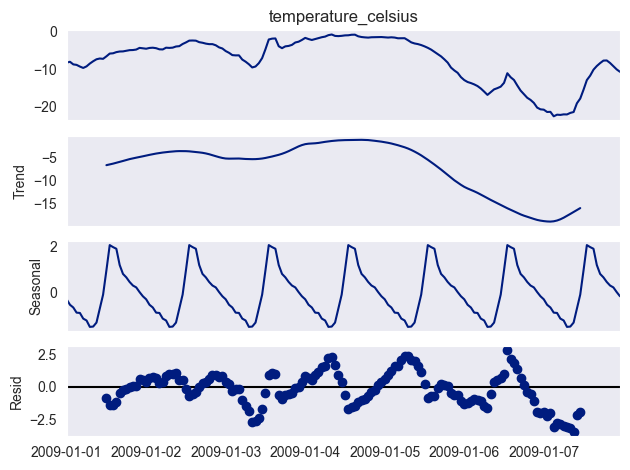

In [7]:
period = 24
n = 7
print("Sazonalidade Diária")
decomposition = seasonal_decompose(df[target].head(period*n), model='additive', period=period)
plt.figure(figsize=(20, 8))
decomposition.plot()
plt.show()

Sazonalidade Mensal


<Figure size 2000x800 with 0 Axes>

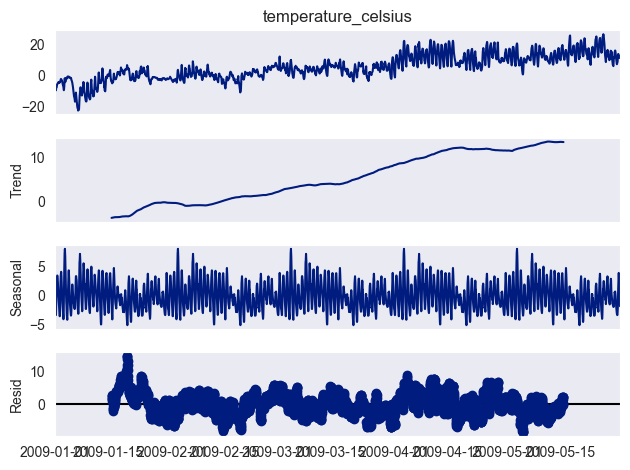

In [8]:
print("Sazonalidade Mensal")
period = 24*30
n = 5
decomposition = seasonal_decompose(df[target].head(period*n), model='additive', period=period)
plt.figure(figsize=(20, 8))
decomposition.plot()
plt.show()

Sazonalidade Anual


<Figure size 2000x800 with 0 Axes>

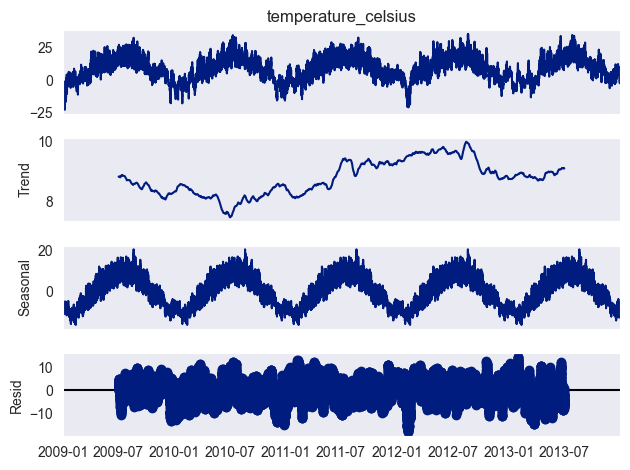

In [9]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
period = 24*365
n = 5
decomposition = seasonal_decompose(df[target].head(period*n), model='additive', period=period)
print("Sazonalidade Anual")
plt.figure(figsize=(20, 8))
decomposition.plot()
plt.show()

# Modelagem

In [10]:
corr_cols = df[exog_variables+[target]].corr()
corr_cols[(corr_cols.abs() > 0.8)&(corr_cols < 1)].dropna(axis=1, how='all')
# df[["internal_pressure", "relative_humidity", "wind_speed", "saturation_vapor_pressure", "temperature_celsius"]].corr()


,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,airtight,days_since_beginning,year,temperature_celsius
internal_pressure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dew_point,NaN,NaN,0.800476,0.968384,NaN,-0.886004,NaN,NaN,0.895919
relative_humidity,NaN,NaN,NaN,NaN,-0.843703,NaN,NaN,NaN,NaN
saturation_vapor_pressure,0.800476,NaN,NaN,0.826423,0.875722,-0.901589,NaN,NaN,0.943843
vapor_pressure,0.968384,NaN,0.826423,NaN,NaN,-0.851269,NaN,NaN,0.868342
vapor_pressure_deficit,NaN,-0.843703,0.875722,NaN,NaN,NaN,NaN,NaN,NaN
airtight,-0.886004,NaN,-0.901589,-0.851269,NaN,NaN,NaN,NaN,-0.956606
wind_speed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wind_direction_degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
days_since_beginning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992157,NaN


In [11]:
FEATURES = ["vapor_pressure", "relative_humidity", "wind_speed", "internal_pressure"]
corr_cols = df[FEATURES].corr()
corr_cols

,vapor_pressure,relative_humidity,wind_speed,internal_pressure
vapor_pressure,1.000000,-0.153347,-0.070604,-0.054334
relative_humidity,-0.153347,1.000000,-0.324645,-0.018268
wind_speed,-0.070604,-0.324645,1.000000,-0.220097
internal_pressure,-0.054334,-0.018268,-0.220097,1.000000


Train Data Shape: (17496,)
Test Data Shape: (25,)


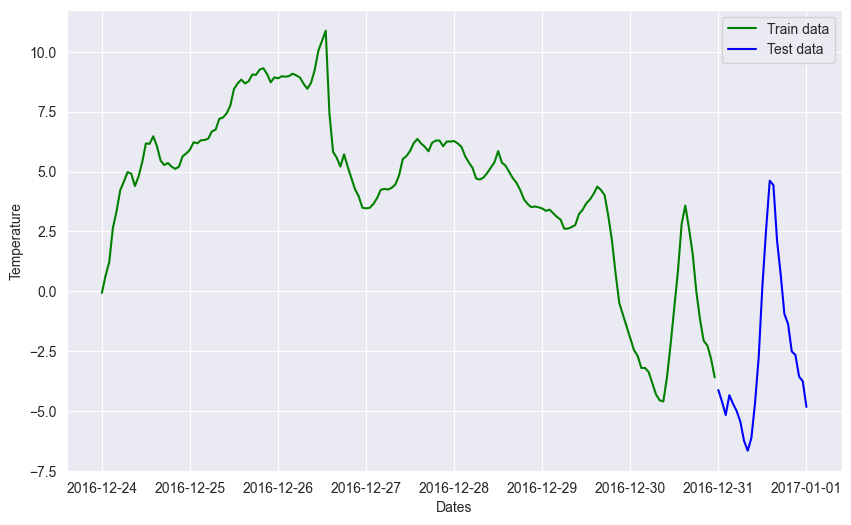

In [12]:
FEATURES = ["airtight", "relative_humidity", "wind_speed", "internal_pressure"]
train_data = df[(df.index.date < date(2016,12,31))&(df.index.date > date(2015,1,1))][target]
train_data_exog = df[(df.index.date < date(2016,12,31))&(df.index.date > date(2015,1,1))][FEATURES]

test_data = df[df.index.date>=date(2016,12,31)][target]
test_data_exog = df[df.index.date>=date(2016,12,31)][FEATURES]

print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Temperature')
plt.plot(train_data[-24*7:], 'green', label='Train data')
plt.plot(test_data[-24*7:], 'blue', label='Test data')
plt.legend()

# Treinando o SARIMA

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data_exog = scaler.fit_transform(train_data_exog)
test_data_exog = scaler.fit_transform(test_data_exog)

In [14]:
p, d, q = 1, 1, 1 # baseado na PACF, Dickey-Fuller e PACF
P, D, Q, s = 1, 1, 1, 24   # s=365 para dados diários com sazonalidade anual

# Ajustando o modelo SARIMA
model = SARIMAX(train_data, 
                exog = train_data_exog,
                order=(p, d, q), 
                seasonal_order=(P, D, Q, s),
                )

sarima_result = model.fit(disp=False)

print(sarima_result.summary())

/Users/marianebando/Library/Caches/pypoetry/virtualenvs/jena-climate-dataset-_40PE9EE-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                temperature_celsius   No. Observations:                17496
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -15503.338
Date:                            Tue, 12 Nov 2024   AIC                          31024.677
Time:                                    11:53:19   BIC                          31094.592
Sample:                                01-02-2015   HQIC                         31047.702
                                     - 12-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -30.9760      1.245    -24.879      0.000     -33.416     -28.536
x2             3.3704      0.117   

### Análise dos resíduos

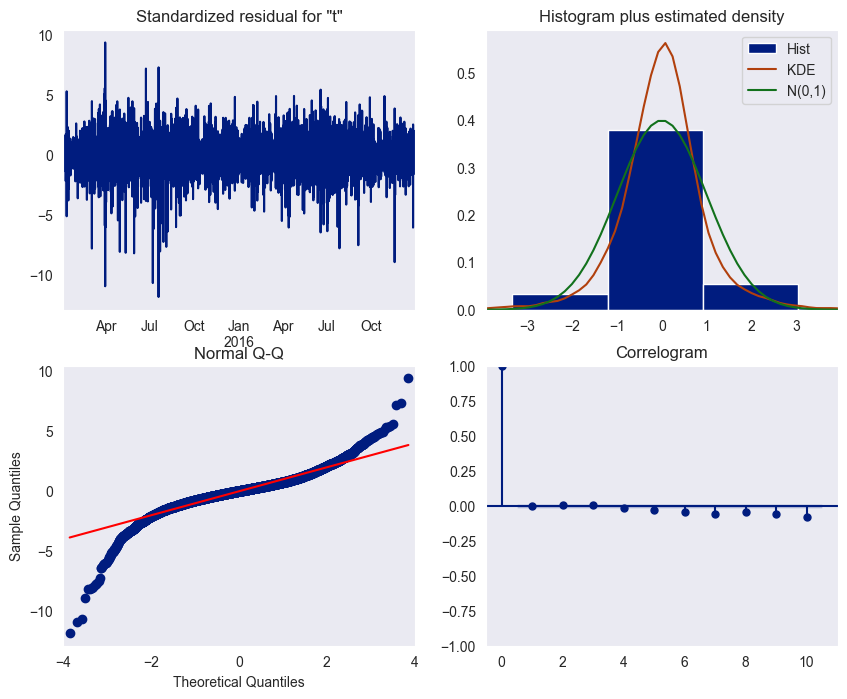

In [15]:
sarima_result.plot_diagnostics(figsize=(10,8))
plt.show()

Para o ARIMA, a normalidade dos resíduos é uma suposição importante para garantir que as inferências e previsões sejam confiáveis.

1. Pelo gráfico 1, os resíduos estão distribuidos ao redor de 0, sem tendência e tem uma variância uniforme. Isso significa que o modelo capturou alguma estrutura de dados.
2. Pelo gráfico 2 e 3, vemos que os resíduos estão normalmente distruibuidos ao redor de 0, mas parece haver uma assimetria positiva, onde a parte superior do gráfico está acima da linha reta, enquanto a parte inferior está abaixo.
- Isso implica que o intervalo de confiança do modelo pode estar subestimado ou superestimado, afetando a precisão das previsões.
- Pode ser que haja não lineariedade nos dados.
4. No gráfico 4, é possível ver que autocorrelação está em torno de 0, ou seja, o resíduo não tem correlação temporal significativa (e o modelo conseguiu ser bem explicado com as features disponíveis).



In [ ]:
# Previsão para o conjunto de treino e teste
y_train_pred = sarima_result.predict(start=train_data.index[0], end=train_data.index[-1], exog=train_data_exog)
y_test_pred = sarima_result.predict(start=test_data.index[0], end=test_data.index[-1], exog=test_data_exog)

# Calcular o erro no treino e teste
mae_train = mean_absolute_error(train_data, y_train_pred)
mae_test = mean_absolute_error(test_data, y_test_pred)

print(f"MAE Treino: {mae_train:.2f}")
print(f"MAE Teste: {mae_test:.2f}")

# Walk Forward Validation

In [ ]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 24
lst_mae, y_pred_lst, y_true_lst = [], [], []
initial_params = sarima_result.params
current_train_end = date(2016,11,1)
test_end_date = date(2016,12,31)

while current_train_end <= test_end_date:
    train_data = df[(df.index.date>=date(2015,1,1))&(df.index.date<current_train_end)][target]
    train_data_exog = df[(df.index.date>=date(2015,1,1))&(df.index.date<current_train_end)][FEATURES]
    test_data = df[df.index.date==current_train_end][target]
    test_data_exog = df[df.index.date==current_train_end][FEATURES]
    # Build Model
    # Ajustando o modelo SARIMA
    model = SARIMAX(train_data, 
                    exog = train_data_exog,
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, s),
                    )

    sarima_result = model.fit(disp=False, start_params=initial_params)
    test_forecast = sarima_result.get_forecast(
            steps=len(test_data.index), 
            exog = test_data_exog
        )
    forecast_ci = test_forecast.conf_int()

    test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data.index)
    y_pred_lst.append(test_forecast_series)
    y_true_lst.append(test_data)
    # Calculate the mean squared error
    mae = mean_absolute_error(test_data, test_forecast_series)
    lst_mae.append(mae)
    initial_params = sarima_result.params
    
    print(f"MAE do dia {current_train_end}: {mae}")
    current_train_end = current_train_end + pd.Timedelta(days=1)

MAE do dia 2016-11-01: 1.4255196370657135
MAE do dia 2016-11-02: 0.9572754325103773
MAE do dia 2016-11-03: 0.5010024372578973
MAE do dia 2016-11-04: 0.3570975297134813
MAE do dia 2016-11-05: 1.1589462687138148
MAE do dia 2016-11-06: 0.30275368840527567
MAE do dia 2016-11-07: 1.0005354136789069
MAE do dia 2016-11-08: 0.5862324929906485
MAE do dia 2016-11-09: 0.44125878152553977
MAE do dia 2016-11-10: 1.1502958725606192
MAE do dia 2016-11-11: 0.7522765038443074
MAE do dia 2016-11-12: 0.5758270668255455
MAE do dia 2016-11-13: 0.6128009979090008
MAE do dia 2016-11-14: 0.9927908597896904
MAE do dia 2016-11-15: 1.0243598864978127
MAE do dia 2016-11-16: 0.5699332412788146
MAE do dia 2016-11-17: 0.550168966035286
MAE do dia 2016-11-18: 1.3521768881739824
MAE do dia 2016-11-19: 1.5631903576138537


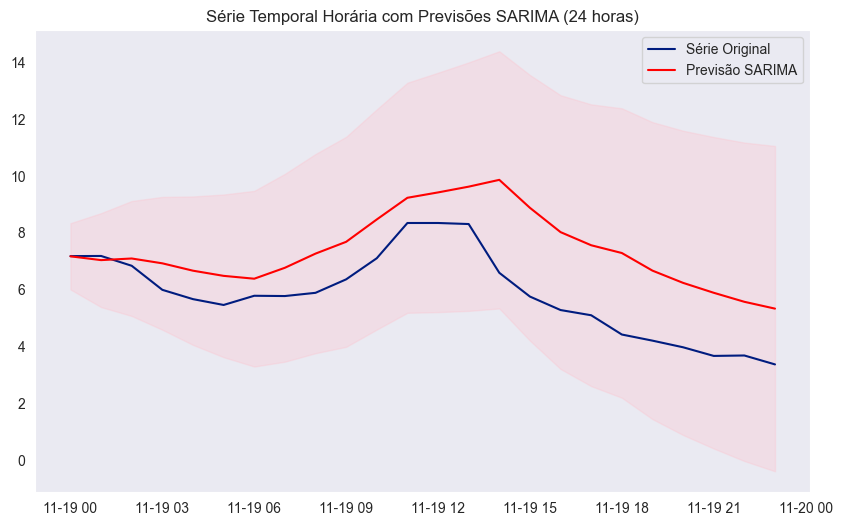

In [52]:
# Plotando as previsões junto com a série original
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Série Original')
plt.plot(test_forecast.predicted_mean, label='Previsão SARIMA', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Série Temporal Horária com Previsões SARIMA (24 horas)")
plt.legend()
plt.show()

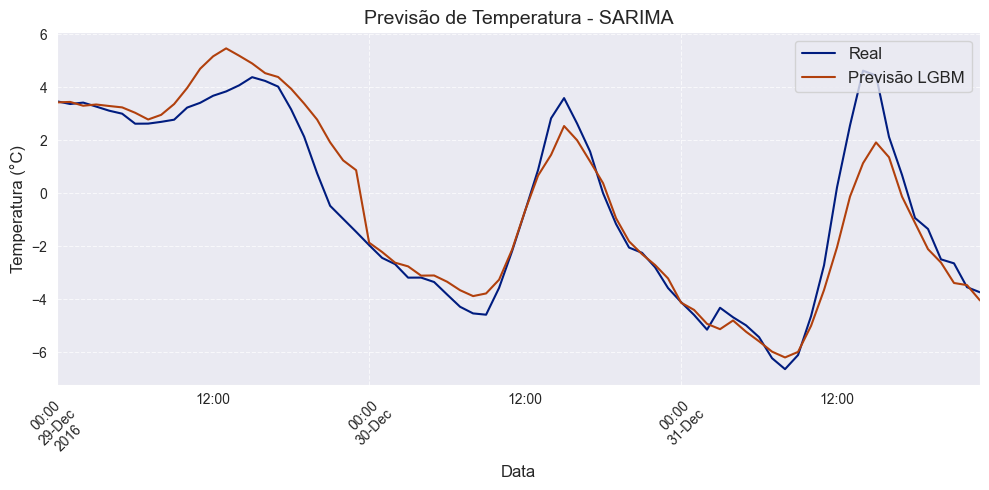

In [53]:
# Plotando as previsões junto com a série original
df_temp = pd.concat(y_true_lst).to_frame()
df_temp = pd.concat([df_temp, pd.concat(y_pred_lst).to_frame()],axis = 1)
df_temp = df_temp.sort_index()
legend_labels = ['Real', 'Previsão LGBM']
filter_start_date = date(2016, 12, 28)

plot_forecast(
    y_true=df_temp["temperature_celsius"],
    y_pred=df_temp["predicted_mean"],
    title='Previsão de Temperatura - SARIMA',
    filter_start_date=filter_start_date,
    xlabel='Data',
    ylabel='Temperatura (°C)',
    legend_labels=legend_labels
)

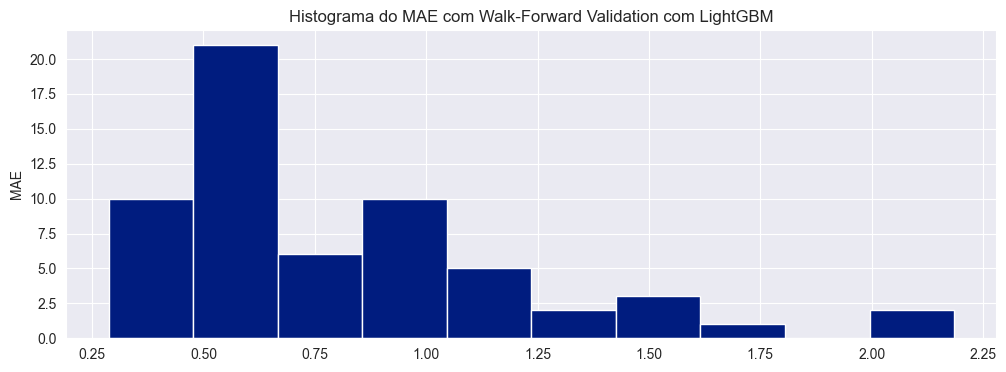

In [58]:
# # 3. Plotar a distribuição do MAE ao longo do tempo
plt.figure(figsize=(12, 4))
plt.hist(lst_mae[1:])
# plt.xlabel('Data')
plt.ylabel('MAE')
plt.title('Histograma do MAE com Walk-Forward Validation com LightGBM')
plt.grid()
plt.show()

In [68]:
ic = calculate_ic(lst_mae, confidence=0.95)
# # Resultados
print(f"N samples: {len(lst_mae)}")
print(f"MAE médio: {np.mean(lst_mae):.4f}")
print(f"MAE desvio padrão: {np.std(lst_mae):.4f}")
print(f"Intervalo de Confiança de 95%: {ic}")

N samples: 61
MAE médio: 0.8165
MAE desvio padrão: 0.4198
Intervalo de Confiança de 95%: (0.7103125842213657, 0.9227452186190294)


In [67]:
pd.Series(lst_mae).to_csv("../data/lst_mae_sarimax.csv")
df_temp.to_csv("../data/pred_sarimax.csv")